## Imports

In [1]:
%autosave 120
import pandas as pd
import plotly.express as px
import torch
from einops import rearrange
import torch
from tqdm.notebook import tqdm
from jaxtyping import Float
from transformer_lens.hook_points import HookPoint
from dataclasses import dataclass
from copy import deepcopy
from functools import partial
from IPython.display import display, clear_output
import ipywidgets
import plotly.subplots as sp


# Import stuff
import torch
from functools import partial
import transformer_lens.utils as utils
import plotly.express as px
torch.set_grad_enabled(False)
device = utils.get_device()
# modified from neel nanda's examples
def imshow(tensor, renderer=None, xaxis="", yaxis="", font_size=None, show=True, color_continuous_midpoint=0.0, fix_size=False, **kwargs):
    fig = px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=color_continuous_midpoint, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs)
    if not font_size is None:
        if 'x' in kwargs:
            fig.update_layout(
              xaxis = dict(
                tickmode='array',
                tickvals = kwargs['x'],
                ticktext = kwargs['x'], 
                ),
               font=dict(size=font_size, color="black"))
        if 'y' in kwargs:
            fig.update_layout(
              yaxis = dict(
                tickmode='array',
                tickvals = kwargs['y'],
                ticktext = kwargs['y'], 
                ),
               font=dict(size=font_size, color="black"))
    if fix_size:
        # default settings aren't very good, these are better
        plot_args = {
            'width': 800,
            'height': 600,
            "autosize": False,
            'showlegend': True,
            'margin': {"l":0,"r":0,"t":100,"b":0}
        }
        
        fig.update_layout(**plot_args)
        fig.update_layout(legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        ))
    if show:
        fig.show(renderer)
    else:
        return fig

def show(data, x, xaxis, yaxis, title, clipped):
    if clipped:
        imshow(data[:,2:], x=x[2:], xaxis=xaxis, yaxis=yaxis, title=title)
    else:
        imshow(data, x=x, xaxis=xaxis, yaxis=yaxis, title=title)

def line(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.line(utils.to_numpy(tensor), labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)


def bar_chart(data, x_labels, y_label, title, font_size=None):
    # it requires a pandas dict with the columns and rows named, annoying
    # by default rows and columns are named with ints so we relabel them accordingly
    renames = dict([(i, x_labels[i]) for i in range(len(x_labels))])
    ps = pd.DataFrame(data.cpu().numpy()).rename(renames, axis='rows').rename({0: y_label}, axis='columns')
    fig = px.bar(ps, y=y_label, x=x_labels, title=title)
    if not font_size is None:
        fig.update_layout(
          xaxis = dict(
            tickmode='array',
            tickvals = x_labels,
            ticktext = x_labels, 
            ),
           font=dict(size=font_size, color="black"))
        
        #fig.update_xaxes(title_font=dict(size=font_size))
    
    fig.show()


Autosaving every 120 seconds


## Load Model

In [2]:
from mamba_lens import HookedMamba
model = HookedMamba.from_pretrained("state-spaces/mamba-370m", device='cuda')
#from transformer_lens import HookedTransformer
#model = HookedTransformer.from_pretrained("gpt2-large")
torch.set_grad_enabled(False)

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Moving model to device:  cuda


## Utility Functions

In [3]:
def get_pad_token(tokenizer):
    return tokenizer.pad_token_id

# given data that is [N,V] and indicies that are [N,K] with each index being an index into the V space
# this does what you'd want, it indexes them
# idk, see the test
def index_into(data, indices):
    num_data, num_per_data = indices.size()
    # we want
    # [0,0,0,...,] num per data of these
    # [1,1,1,...,] num per data of these
    # ...
    # [num_data-1, num_data-1, ...]
    first_axis_index = torch.arange(num_data, dtype=torch.long).view(num_data, 1)*torch.ones([num_data, num_per_data], dtype=torch.long)
    # now we flatten it so it has an index for each term aligned with our indices
    first_axis_index = first_axis_index.flatten()

    second_axis_index = indices.flatten()
    # now we can just index, and then view back to our original shape
    return data[first_axis_index, second_axis_index].view(num_data, num_per_data)

def eval_debug(model, data, correct, incorrect, constrain_to_answers, **kwargs):
    for data_i in range(correct.size()[0]):
        input = model.tokenizer.decode(data[data_i])
        top_k = 2
        logits = model.forward(input, **kwargs)[0,-1]
        correct_answers = correct[data_i]
        incorrect_answers = incorrect[data_i]
        if constrain_to_answers:
            only_consider_answer_logits = torch.full(logits.size(), fill_value=-torch.inf, device=model.cfg.device)
            only_consider_answer_logits[correct_answers] = logits[correct_answers]
            only_consider_answer_logits[incorrect_answers] = logits[incorrect_answers]
            logits = only_consider_answer_logits
        prs = torch.nn.functional.softmax(logits, dim=0)
        top = torch.argsort(-logits)[:top_k]
        printed = False
        printed_prompt = False
        for i, tok in enumerate(top):
            if not i == 0 and tok in correct_answers:
                if not printed_prompt:
                    print("prompt", input)
                    printed_prompt = True
                print(f"  correct top {i} token {repr(model.tokenizer.decode([tok]))} logit {logits[tok]} prs {prs[tok]}")
                printed = True
                #print("correct")
                #print(f"token {model.tokenizer.decode([tok])} logit {logits[tok]} prs {prs[tok]}")
            elif i == 0 and not tok in correct_answers:
                if not printed_prompt:
                    print("prompt", input)
                    printed_prompt = True
                print(f"  incorrect top {i} token {repr(model.tokenizer.decode([tok]))} logit {logits[tok]} prs {prs[tok]}")
                printed = True
            if tok in correct_answers:
                break
        if printed:
            print()

def eval(model, data, correct, incorrect, constrain_to_answers, **kwargs):
        num_examples = correct.size()[0]
        logits = model(data, **kwargs)[:,-1]
        pad = get_pad_token(tokenizer=model.tokenizer)
        logits[:,pad] = -torch.inf # manually set pad pr to -inf logit because sometimes we need to pad num correct or num incorrect

        n_data, n_correct = correct.size()
        n_data, n_incorrect = incorrect.size()

        if constrain_to_answers:
            # [n_data, n_correct]
            correct_logits = index_into(logits, correct)
            # [n_data, n_incorrect]
            incorrect_logits = index_into(logits, incorrect)
            # [n_data, n_correct + n_incorrect]
            combined_logits = torch.concatenate([correct_logits, incorrect_logits], dim=1)
            combined_prs = torch.softmax(combined_logits, dim=1)
            biggest = torch.argsort(-combined_prs, dim=1)
            # if biggest pr is in the correct, we are correct, otherwise, we are not
            num_correct = torch.sum(biggest[:,0] < n_correct)
    
            correct_prs, incorrect_prs = combined_prs.split([n_correct, n_incorrect], dim=1)
        else:
            prs = torch.nn.functional.softmax(logits, dim=1)
            # [n_data, n_correct]
            correct_prs = index_into(prs, correct)
            # [n_data, n_incorrect]
            incorrect_prs = index_into(prs, incorrect)
            # [n_data, 1]
            top_tokens = torch.topk(logits, 1, dim=1).indices
            # [n_data, n_correct]
            in_correct = top_tokens == correct
            # [n_data]
            has_any_correct = torch.any(in_correct, dim=1)
            # [1]
            num_correct = torch.sum(has_any_correct)
    
        # the sum(dim=1) is because we or of all the different possible probabilities by summing
        # then we'll just report the average
        return torch.mean(correct_prs.sum(dim=1)).item(), torch.mean(incorrect_prs.sum(dim=1)).item(), num_correct.item()/float(n_data)


def add_padding_answers(tokenizer, answers):
    longest_len = len(max(answers, key=lambda x: len(x)))
    padded_answers = []
    pad_token = get_pad_token(tokenizer=tokenizer)
    for answer in answers:
        padded_answers.append(answer + [pad_token]*(longest_len-len(answer)))
    return padded_answers

def get_batched_data(data):
    batched_data = []
    batched_correct = []
    batched_incorrect = []

    bos = [model.tokenizer.bos_token_id]
    
    for i, (prompt, corrects, incorrects) in enumerate(data):
        if i < 7:
            print(prompt, corrects, incorrects)
        batched_data.append(torch.tensor(bos + model.tokenizer.encode(prompt), device=model.cfg.device))
        batched_correct.append([model.tokenizer.encode(correct)[0] for correct in corrects])
        batched_incorrect.append([model.tokenizer.encode(incorrect)[0] for incorrect in incorrects])
    try:
        batched_data = torch.stack(batched_data)
        batched_correct = torch.tensor(add_padding_answers(tokenizer=model.tokenizer, answers=batched_correct), device=model.cfg.device)
        batched_incorrect = torch.tensor(add_padding_answers(tokenizer=model.tokenizer, answers=batched_incorrect), device=model.cfg.device)
    except RuntimeError:
        typical_len = len(batched_data[0])
        for s in batched_data:
            if not len(s) == typical_len:
                print(len(s), "is len of this, typical len is", typical_len, "for sequence", model.to_str_tokens(s))
        raise
    return batched_data, batched_correct, batched_incorrect

## Generate Data

In [4]:
from docstring import docstring_prompt_generator_function
from importlib import reload
import test_data
reload(test_data)
from test_data import IOI_generator, BABA_TEMPLATES, greater_than_data_generator, ABC_TEMPLATES, copy_generator, IOI_custom_generator

num_examples = 2000

seed = 27
valid_seed = 37
test_seed = 47

# todo: move name tokens further apart so they can't use conv
data_type = 'ioi custom'

constrain_to_answers = True

if data_type == 'ioi':
    data = IOI_generator(templates=[BABA_TEMPLATES[1]], tokenizer=model.tokenizer, num_examples=num_examples, symmetric=True, seed=seed)
    valid_data = IOI_generator(templates=[BABA_TEMPLATES[1]], tokenizer=model.tokenizer, num_examples=num_examples, symmetric=True, seed=valid_seed)
    test_data = IOI_generator(templates=[BABA_TEMPLATES[1]], tokenizer=model.tokenizer, num_examples=num_examples, symmetric=True, seed=test_seed)
elif data_type == 'ioi custom':
    ioi_format = """
AB A B
AB B A""".strip()
    data = IOI_custom_generator(ioi_format=ioi_format, tokenizer=model.tokenizer, num_examples=num_examples, seed=seed)
    valid_data = IOI_custom_generator(ioi_format=ioi_format, tokenizer=model.tokenizer, num_examples=num_examples, seed=valid_seed)
    test_data = IOI_custom_generator(ioi_format=ioi_format, tokenizer=model.tokenizer, num_examples=num_examples, seed=test_seed)
elif data_type == 'docstring':
    data = docstring_prompt_generator_function(tokenizer=model.tokenizer, num_examples=num_examples, corrupt='random_answer', seed=seed)
    valid_data = docstring_prompt_generator_function(tokenizer=model.tokenizer, num_examples=num_examples, corrupt='random_answer', seed=valid_seed)
    test_data = docstring_prompt_generator_function(tokenizer=model.tokenizer, num_examples=num_examples, corrupt='random_answer', seed=test_seed)
elif data_type == 'greater than':
    constrain_to_answers = False
    data = greater_than_data_generator(tokenizer=model.tokenizer, num_examples=num_examples, seed=seed)
    valid_data = greater_than_data_generator(tokenizer=model.tokenizer, num_examples=num_examples, seed=valid_seed)
    test_data = greater_than_data_generator(tokenizer=model.tokenizer, num_examples=num_examples, seed=test_seed)
elif data_type == 'copy':
    constrain_to_answers = False
    copy_seq_len = 4
    data = copy_generator(tokenizer=model.tokenizer, num_examples=num_examples, copy_seq_len=copy_seq_len, seed=seed)
    valid_data = copy_generator(tokenizer=model.tokenizer, num_examples=num_examples, copy_seq_len=copy_seq_len, seed=valid_seed)
    test_data = copy_generator(tokenizer=model.tokenizer, num_examples=num_examples, copy_seq_len=copy_seq_len, seed=test_seed)

print("data")
batched_data, batched_correct, batched_incorrect = get_batched_data(data)
print("\n\nvalid\n")
vbatched_data, vbatched_correct, vbatched_incorrect = get_batched_data(valid_data)
print("\n\ntest")
tbatched_data, tbatched_correct, tbatched_incorrect = get_batched_data(test_data)

relative_str = ' relative ' if constrain_to_answers else ' '


data
Lately, Dale and Jerry had fun at the restaurant. Dale gave a ring to [' Jerry'] [' Dale']
Lately, Dale and Jerry had fun at the restaurant. Jerry gave a ring to [' Dale'] [' Jerry']
Lately, Raf and Judy had fun at the house. Raf gave a drink to [' Judy'] [' Raf']
Lately, Raf and Judy had fun at the house. Judy gave a drink to [' Raf'] [' Judy']
Lately, Lindsey and Sandra had fun at the store. Lindsey gave a snack to [' Sandra'] [' Lindsey']
Lately, Lindsey and Sandra had fun at the store. Sandra gave a snack to [' Lindsey'] [' Sandra']
Lately, Teresa and Lib had fun at the hospital. Teresa gave a drink to [' Lib'] [' Teresa']


valid

Lately, Florida and Max had fun at the office. Florida gave a ring to [' Max'] [' Florida']
Lately, Florida and Max had fun at the office. Max gave a ring to [' Florida'] [' Max']
Lately, Theresa and Heather had fun at the garden. Theresa gave a necklace to [' Heather'] [' Theresa']
Lately, Theresa and Heather had fun at the garden. Heather gave a n

## Patching

See [MambaLens](https://github.com/Phylliida/MambaLens) for a list of all the hooks available.

set `fast_conv=True` unless you are patching on conv

set `fast_ssm=True` unless you are patching on `h`, `delta`, `A_bar`, `B_bar`, or `y`

(you can set them both to False always, it'll just be slower)

There are a few special ones:

## `skip h`

This sets the hidden state contribution at the target position and layer to 0.

In other words, where normally the hidden state at that position would be

$$h_{pos+1} = Ah_{pos} + Bx$$

Now it is just

$$h_{pos+1} = Ah_{pos}$$

## `h_n`

Patches on the N different E-sized hidden states

Note that patching on `h_n` is hardcoded to layer 39 via

```
H_N_PATCHING_LAYER = 39
```

You can change this to pick a different layer

In [8]:
# modified from neel nanda's examples

H_N_PATCHING_LAYER = 39

# default settings aren't very good, these are better
plot_args = {
    'width': 800,
    'height': 600,
    "autosize": False,
    'showlegend': True,
    'margin': {"l":0,"r":0,"t":100,"b":0}
}

#limited_layers = [0, 3, 10, 14, 15, 17, 18, 21, 22, 25, 26, 27, 28, 33, 36, 39, 40, 45, 46]
limited_layers = list(range(model.cfg.n_layers))

# grab first two data points as patching inputs
# the data generators will pair things nicely
# you can also just replace these with two strings
prompt_uncorrupted = model.tokenizer.decode(batched_data[0][1:])
prompt_corrupted = model.tokenizer.decode(batched_data[1][1:])

answer_tokens = sorted(list(set([x.item() for x in batched_correct[0]] + [x.item() for x in batched_correct[1]] + [x.item() for x in batched_incorrect[0]] + [x.item() for x in batched_incorrect[1]])))
uncorrupted_answer = model.tokenizer.decode([batched_correct[0,0]])
corrupted_answer = model.tokenizer.decode([batched_correct[1,0]])

def wrap_run_with_hooks(model, fwd_hooks, **kwargs):
    def wrapper(input):
        return model.run_with_hooks(input, fwd_hooks=fwd_hooks, **kwargs)
    wrapper.tokenizer = model.tokenizer
    return wrapper

# constrain_to_answers will constrain generation to only outputting those answers
correct, incorrect, acc = eval(
                            wrap_run_with_hooks(model=model, fwd_hooks=[], only_use_these_layers=limited_layers),
                            vbatched_data, vbatched_correct, vbatched_incorrect,
                            constrain_to_answers=constrain_to_answers)

# if you are doing constrain_to_answers, the prs will be relative (so within the given answers the pr will sum to 1)
# otherwise they will just be the prs given by softmax of the logits
print(f"baseline correct{relative_str}pr {correct} incorrect{relative_str}pr {incorrect} accuracy {acc}")

prompt_uncorrupted_tokens = model.to_tokens(prompt_uncorrupted)
prompt_corrupted_tokens = model.to_tokens(prompt_corrupted)

# logits should be [B,L,V] 
def uncorrupted_logit_minus_corrupted_logit(logits, uncorrupted_answer, corrupted_answer):
    uncorrupted_index = model.to_single_token(uncorrupted_answer)
    corrupted_index = model.to_single_token(corrupted_answer)
    return logits[0, -1, uncorrupted_index] - logits[0, -1, corrupted_index]

# prs should be [B,L,V] 
def uncorrupted_pr_minus_corrupted_pr(prs, uncorrupted_answer, corrupted_answer):
    uncorrupted_index = model.to_single_token(uncorrupted_answer)
    corrupted_index = model.to_single_token(corrupted_answer)
    return prs[0, -1, uncorrupted_index] - prs[0, -1, corrupted_index]

# [B,L,V]
corrupted_logits, corrupted_activations = model.run_with_cache(prompt_corrupted_tokens, only_use_these_layers=limited_layers)
corrupted_logit_diff = uncorrupted_logit_minus_corrupted_logit(logits=corrupted_logits, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)
corrupted_prs = torch.softmax(corrupted_logits, dim=2)
corrupted_pr_diff = uncorrupted_pr_minus_corrupted_pr(prs=corrupted_prs, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)

# [B,L,V]
uncorrupted_logits = model(prompt_uncorrupted_tokens, only_use_these_layers=limited_layers)
uncorrupted_logit_diff = uncorrupted_logit_minus_corrupted_logit(logits=uncorrupted_logits, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)
uncorrupted_prs = torch.softmax(uncorrupted_logits, dim=2)
uncorrupted_pr_diff = uncorrupted_pr_minus_corrupted_pr(prs=uncorrupted_prs, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)

uncorrupted_index = model.to_single_token(uncorrupted_answer)
corrupted_index = model.to_single_token(corrupted_answer)
print(f'uncorrupted prompt\n{prompt_uncorrupted}')
print(f"{repr(uncorrupted_answer)} logit {uncorrupted_logits[0,-1,uncorrupted_index]}")
print(f"{repr(uncorrupted_answer)} pr {uncorrupted_prs[0,-1,uncorrupted_index]}")
print(f"{repr(corrupted_answer)} logit {uncorrupted_logits[0,-1,corrupted_index]}")
print(f"{repr(corrupted_answer)} pr {uncorrupted_prs[0,-1,corrupted_index]}")
print(f'\ncorrupted prompt\n{prompt_corrupted}')
print(f"{repr(uncorrupted_answer)} logit {corrupted_logits[0,-1,uncorrupted_index]}")
print(f"{repr(uncorrupted_answer)} pr {corrupted_prs[0,-1,uncorrupted_index]}")
print(f"{repr(corrupted_answer)} logit {corrupted_logits[0,-1,corrupted_index]}")
print(f"{repr(corrupted_answer)} pr {corrupted_prs[0,-1,corrupted_index]}")

# We make a tensor to store the results for each patching run. We put it on the model's device to avoid needing to move things between the GPU and CPU, which can be slow.
L = len(prompt_uncorrupted_tokens[0])
if len(prompt_corrupted_tokens[0]) != len(prompt_uncorrupted_tokens[0]):
    raise Exception("Prompts are not the same length") # feel free to comment this out, you can patch for different sized prompts its just a lil sus

# diff is logit of uncorrupted_answer - logit of corrupted_answer
# we expect corrupted_diff to have a negative value (as corrupted should put high pr on corrupted_answer)
# we expect uncorrupted to have a positive value (as uncorrupted should put high pr on uncorrupted_answer)
# thus we can treat these as (rough) min and max possible values
min_logit_diff = corrupted_logit_diff
max_logit_diff = uncorrupted_logit_diff

min_pr_diff = corrupted_pr_diff
max_pr_diff = uncorrupted_pr_diff

# make token labels that describe the patch
corrupted_str_tokens = model.to_str_tokens(prompt_corrupted_tokens)
uncorrupted_str_tokens = model.to_str_tokens(prompt_uncorrupted_tokens)
token_labels = []
for index, (corrupted_token, uncorrupted_token) in enumerate(zip(corrupted_str_tokens, uncorrupted_str_tokens)):
    if corrupted_token == uncorrupted_token:
        token_labels.append(f"{corrupted_token}_{index}")
    else:
        token_labels.append(f"{uncorrupted_token}->{corrupted_token}_{index}")

def run_patching(patching_type, patching_hook_name_func, patching_hook_func, show_options, show_plot=True, **kwargs):
    hook_title = patching_hook_name_func(layer='{layer}', position='{position}')
    print(f"running patching {patching_type}, using hook {hook_title}")
    global patching_result_logits, patching_result_prs # if you want to access it once this is done running
    n_layers = len(limited_layers)

    if patching_type == H_N_PATCHING:
        print(f"on layer H_N_PATCHING_LAYER={H_N_PATCHING_LAYER}")
        N = model.cfg.N
        patching_result_normalized_logits = torch.zeros((N, L), device=model.cfg.device)
        patching_result_normalized_prs = torch.zeros((N, L), device=model.cfg.device)
    
        num_answers = len(answer_tokens)
        patching_result_logits = torch.zeros((N, L, num_answers), device=model.cfg.device)
        patching_result_prs = torch.zeros((N, L, num_answers), device=model.cfg.device)
    else:
        patching_result_normalized_logits = torch.zeros((n_layers, L), device=model.cfg.device)
        patching_result_normalized_prs = torch.zeros((n_layers, L), device=model.cfg.device)
    
        num_answers = len(answer_tokens)
        patching_result_logits = torch.zeros((n_layers, L, num_answers), device=model.cfg.device)
        patching_result_prs = torch.zeros((n_layers, L, num_answers), device=model.cfg.device)

    hooks = []
    # skipping h needs A_bar stored, so also add that hook
    if patching_type == SKIPPING_H_PATCHING:
        for i, layer in list(enumerate(limited_layers)):
            hooks.append((f'blocks.{layer}.hook_A_bar', partial(A_bar_storage_hook_for_skipping_h, layer=layer)))

    # skipping layer needs layer_input (resid_pre) stored, so also add that hook
    if patching_type == LAYER_SKIPPING:
        for i, layer in list(enumerate(limited_layers)):
            hooks.append((f'blocks.{layer}.hook_resid_pre', partial(layer_input_storage_hook, layer=layer)))
    
    if patching_type == H_N_PATCHING:
        batch = 0
        indices = []
        for n in range(N):
            for position in range(L):
                patching_hook_name = patching_hook_name_func(layer=H_N_PATCHING_LAYER, position=position)
                patching_hook = partial(patching_hook_func, layer=H_N_PATCHING_LAYER, position=position, n=n, batch=batch)
                batch += 1
                indices.append((n,position))
                hooks.append((patching_hook_name, patching_hook))
    else:
        batch = 0
        indices = []
        for i, layer in list(enumerate(limited_layers)):
            for position in range(L):
                patching_hook_name = patching_hook_name_func(layer=layer, position=position)
                patching_hook = partial(patching_hook_func, layer=layer, position=position, batch=batch)
                batch += 1
                indices.append((i,position))
                hooks.append((patching_hook_name, patching_hook))
    
    # [B,L,V]
    patched_logits = model.run_with_hooks(prompt_uncorrupted_tokens.expand(batch,L), fwd_hooks=hooks, only_use_these_layers=limited_layers, **kwargs)
    # [B,L,V]
    patched_prs = torch.softmax(patched_logits, dim=2)

    for b, (i,position) in enumerate(indices):
        if corrupted_answer != uncorrupted_answer:
            patched_logit_diff = uncorrupted_logit_minus_corrupted_logit(logits=patched_logits[b:b+1],
                                                                         uncorrupted_answer=uncorrupted_answer,
                                                                         corrupted_answer=corrupted_answer)
            # normalize it so
            # 0 means min_logit_diff (so 0 means that it is acting like the corrupted model)
            # 1 means max_logit_diff (so 1 means that it is acting like the uncorrupted model)
            normalized_patched_logit_diff = (patched_logit_diff-min_logit_diff)/(max_logit_diff - min_logit_diff)
            # now flip them, since most interventions will do nothing and thus act like uncorrupted model, visually its better to have that at 0
            # so now
            # 0 means that it is acting like the uncorrupted model
            # 1 means that it is acting like the corrupted model
            normalized_patched_logit_diff = 1.0 - normalized_patched_logit_diff
            patching_result_normalized_logits[i, position] = normalized_patched_logit_diff
            
            # same for pr
            patched_pr_diff = uncorrupted_pr_minus_corrupted_pr(prs=patched_prs[b:b+1],
                                                                uncorrupted_answer=uncorrupted_answer,
                                                                corrupted_answer=corrupted_answer)
            normalized_patched_pr_diff = 1.0-(patched_pr_diff-min_pr_diff)/(max_pr_diff - min_pr_diff)
            patching_result_normalized_prs[i, position] = normalized_patched_pr_diff

        for k, answer_token in enumerate(answer_tokens):
            patching_result_logits[i, position, k] = patched_logits[b,-1,answer_token]
            patching_result_prs[i, position, k] = patched_prs[b,-1,answer_token]
    
        
    if patching_type == H_N_PATCHING:
        layer_labels = [str(n) for n in range(N)]
    else:
        layer_labels = [str(layer) for layer in limited_layers]
    figs = []
    if corrupted_answer != uncorrupted_answer:
        if show_options in [SHOW_LOGITS, SHOW_BOTH]:
            figs.append(imshow(patching_result_normalized_logits, show=False, x=token_labels, y=layer_labels, xaxis="Position", yaxis="Layer", title=f"Normalized logit difference after patching {patching_type} using hook {hook_title}", font_size=8))
        if show_options in [SHOW_PR, SHOW_BOTH]:
            figs.append(imshow(patching_result_normalized_prs, show=False, x=token_labels, y=layer_labels, xaxis="Position", yaxis="Layer", title=f"Normalized pr difference after patching {patching_type} using hook {hook_title}", font_size=8))
    
    for k, answer_token in enumerate(answer_tokens):
        if show_options in [SHOW_LOGITS, SHOW_BOTH]:
            figs.append(imshow(patching_result_logits[:,:,k], color_continuous_midpoint=None, show=False, x=token_labels, y=layer_labels, xaxis="Position", yaxis="Layer", title=f"Logit of uncorrupted answer {repr(model.tokenizer.decode([answer_token]))} after patching {patching_type} using hook {hook_title}", font_size=8))
        if show_options in [SHOW_PR, SHOW_BOTH]:
            figs.append(imshow(patching_result_prs[:,:,k], show=False, x=token_labels, y=layer_labels, xaxis="Position", yaxis="Layer", title=f"Pr of uncorrupted answer {repr(model.tokenizer.decode([answer_token]))} after patching {patching_type} using hook {hook_title}", font_size=8)) 

    for fig in figs:
        fig.update_layout(**plot_args)
        fig.update_layout(legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        ))
        fig.show()



## hooks for layer skipping
def layer_input_storage_hook(
    layer_input: Float[torch.Tensor, "B L D"],
    hook: HookPoint,
    layer: int,
) -> Float[torch.Tensor, "B L D"]:
    global storage
    storage = {}
    storage['layer_input'] = layer_input
    return layer_input

def layer_output_skipping_hook(
    layer_output: Float[torch.Tensor, "B L D"],
    hook: HookPoint,
    position: int,
    layer: int,
    batch: int,
) -> Float[torch.Tensor, "B L D"]:
    global storage
    layer_input = storage['layer_input']
    # intervene on the batch at the position
    layer_output[batch,position,:] = layer_input[batch,position,:]
    return layer_output


## hooks for h skipping
def A_bar_storage_hook_for_skipping_h(
    A_bar: Float[torch.Tensor, "B L E N"],
    hook: HookPoint,
    layer: int,
) -> Float[torch.Tensor, "B L E N"]:
    global storage
    storage = {}
    storage['A_bar'] = A_bar
    return A_bar

def skipping_h_hook(
    h: Float[torch.Tensor, "B E N"],
    hook: HookPoint,
    position: int,
    layer: int,
    batch: int,
) -> Float[torch.Tensor, "B E N"]:
    #print("fetching", storage[grab_pos][0,0,0:5], "from position", grab_pos)
    #print("my value (being ignore) is", h[0,0,0:5])
    #print(f"skipping ahead h at position {position}")
    global storage
    B,E,N = h.size()
    grab_pos = position-1
    if grab_pos < 0:
        h[batch,:,:] = torch.zeros((E,N), device=model.cfg.device)
    else:
        B,E,N = h.size()
        A_contribution = torch.ones((E,N), device=model.cfg.device)
        for missed_pos in range(grab_pos+1, position+1):
            A_contribution *= storage['A_bar'][batch,missed_pos,:,:]
        h_stored = storage[grab_pos][batch,:,:]
        h[batch,:,:] = A_contribution*h_stored
        #return A_contribution*storage[grab_pos]
    storage[position] = h
    return h


## Regular patching hooks
def position_patching_hook( # also works for B L E, B L E N, and B L N sized things
    x: Float[torch.Tensor, "B L D"],
    hook: HookPoint,
    position: int,
    layer: int, # we don't care about this
    batch: int,
) -> Float[torch.Tensor, "B L D"]:
    # only intervene on the specific pos
    corrupted_x = corrupted_activations[hook.name]
    x[batch, position, :] = corrupted_x[0, position, :]
    return x

def h_patching_hook(
    h: Float[torch.Tensor, "B E N"],
    hook: HookPoint,
    position: int,
    layer: int,
    batch: int,
) -> Float[torch.Tensor, "B E N"]:
    corrupted_h = corrupted_activations[hook.name]
    h[batch] = corrupted_h[0]
    return h

def h_n_patching_hook(
    h: Float[torch.Tensor, "B E N"],
    hook: HookPoint,
    position: int,
    layer: int,
    n: int,
    batch: int,
) -> Float[torch.Tensor, "B E N"]:
    corrupted_h = corrupted_activations[hook.name]
    h[batch,:,n] = corrupted_h[0,:,n]
    return h

SKIPPING_H_PATCHING = 'skipping h'
H_N_PATCHING = 'h_n'
LAYER_SKIPPING = 'skipping layer'

patching_types = {
    'normalized input': (lambda layer, position: f'blocks.{layer}.hook_normalized_input', position_patching_hook),
    'layer input': (lambda layer, position: f'blocks.{layer}.hook_resid_pre', position_patching_hook),
    'skip': (lambda layer, position: f'blocks.{layer}.hook_skip', position_patching_hook), 
    'in proj': (lambda layer, position: f'blocks.{layer}.hook_in_proj', position_patching_hook), 
    'conv': (lambda layer, position: f'blocks.{layer}.hook_conv', position_patching_hook), 
    'delta 1': (lambda layer, position: f'blocks.{layer}.hook_delta_1', position_patching_hook), 
    'delta 2': (lambda layer, position: f'blocks.{layer}.hook_delta_2', position_patching_hook), 
    'delta': (lambda layer, position: f'blocks.{layer}.hook_delta', position_patching_hook), 
    'A_bar': (lambda layer, position: f'blocks.{layer}.hook_A_bar', position_patching_hook), 
    'B': (lambda layer, position: f'blocks.{layer}.hook_B', position_patching_hook), 
    'B_bar': (lambda layer, position: f'blocks.{layer}.hook_B_bar', position_patching_hook), 
    'C': (lambda layer, position: f'blocks.{layer}.hook_C', position_patching_hook), 
    'ssm input': (lambda layer, position: f'blocks.{layer}.hook_ssm_input', position_patching_hook),
    SKIPPING_H_PATCHING: (lambda layer, position: f'blocks.{layer}.hook_h.{position}', skipping_h_hook),
    'h': (lambda layer, position: f'blocks.{layer}.hook_h.{position}', h_patching_hook),
    H_N_PATCHING: (lambda layer, position: f'blocks.{layer}.hook_h.{position}', h_n_patching_hook),
    'y': (lambda layer, position: f'blocks.{layer}.hook_y', position_patching_hook),
    'ssm output': (lambda layer, position: f'blocks.{layer}.hook_ssm_output', position_patching_hook),
    'after skip': (lambda layer, position: f'blocks.{layer}.hook_after_skip', position_patching_hook),
    'out proj': (lambda layer, position: f'blocks.{layer}.hook_out_proj', position_patching_hook),
    'resid post': (lambda layer, position: f'blocks.{layer}.hook_resid_post', position_patching_hook),
    LAYER_SKIPPING: (lambda layer, position: f'blocks.{layer}.hook_resid_post', layer_output_skipping_hook),
}

patching_types_keys = list(patching_types.keys())

def choose_patching_type(change):
    if change['type'] == 'change' and change['name'] == 'value':
        choose_patching_type.patching_type = change['new'] # hack, gives this function the patching_type attribute

choose_patching_type.patching_type = patching_types_keys[0]

patching_type_dropdown = ipywidgets.Dropdown(
    options=patching_types_keys,
    value=patching_types_keys[0],
    description='Patching Type',
)
patching_type_dropdown.observe(choose_patching_type)
display(patching_type_dropdown)


fast_conv_keys = ['True', 'False']

def choose_fast_conv(change):
    if change['type'] == 'change' and change['name'] == 'value':
        choose_fast_conv.fast_conv = change['new'] == 'True'

choose_fast_conv.fast_conv = fast_conv_keys[0] == 'True'

choose_fast_conv_dropdown = ipywidgets.Dropdown(
    options=fast_conv_keys,
    value=fast_conv_keys[0],
    description='fast conv',
)
choose_fast_conv_dropdown.observe(choose_fast_conv)
display(choose_fast_conv_dropdown)


fast_ssm_keys = ['False', 'True']

def choose_fast_ssm(change):
    if change['type'] == 'change' and change['name'] == 'value':
        choose_fast_ssm.fast_ssm = change['new'] == 'True'

choose_fast_ssm.fast_ssm = fast_ssm_keys[0] == 'True'

choose_fast_ssm_dropdown = ipywidgets.Dropdown(
    options=fast_ssm_keys,
    value=fast_ssm_keys[0],
    description='fast ssm',
)
choose_fast_ssm_dropdown.observe(choose_fast_ssm)
display(choose_fast_ssm_dropdown)

SHOW_PR = 'Pr'
SHOW_LOGITS = 'Logits'
SHOW_BOTH = 'Both'
show_options = [SHOW_LOGITS, SHOW_PR, SHOW_BOTH]

def choose_show_options(change):
    if change['type'] == 'change' and change['name'] == 'value':
        choose_show_options.show_options = change['new']

choose_show_options.show_options = show_options[0]

show_options_dropdown = ipywidgets.Dropdown(
    options=show_options,
    value=show_options[0],
    description='logits or pr',
)
show_options_dropdown.observe(choose_show_options)
display(show_options_dropdown)

def do_patching(arg, show_plot=True):
    with output: # this lets the stuff we output here be visible
        clear_output()
        patching_type = choose_patching_type.patching_type
        hook_name_func, hook_func = patching_types[patching_type]
        return run_patching(
                     patching_type=patching_type,
                     patching_hook_name_func=hook_name_func,
                     patching_hook_func=hook_func,
                     fast_ssm=choose_fast_ssm.fast_ssm,
                     fast_conv=choose_fast_conv.fast_conv,
                     show_options=choose_show_options.show_options,
                     show_plot=show_plot)

patching_button = ipywidgets.Button(description = 'Run Patching')
patching_button.on_click(do_patching)
display(patching_button)

# you can't just display stuff inside a widget callback, you need a wrap any display code in this
output = ipywidgets.Output()
display(output)


baseline correct relative pr 0.9657200574874878 incorrect relative pr 0.03428000211715698 accuracy 1.0
uncorrupted prompt
Lately, Jerry and Dale had fun at the restaurant. Jerry gave a ring to
' Dale' logit 12.055768966674805
' Dale' pr 0.05545641854405403
' Jerry' logit 8.743332862854004
' Jerry' pr 0.002020128769800067

corrupted prompt
Lately, Jerry and Dale had fun at the restaurant. Dale gave a ring to
' Dale' logit 8.578718185424805
' Dale' pr 0.001230880618095398
' Jerry' logit 12.711100578308105
' Jerry' pr 0.07671615481376648


Dropdown(description='Patching Type', options=('normalized input', 'layer input', 'skip', 'in proj', 'conv', '…

Dropdown(description='fast conv', options=('True', 'False'), value='True')

Dropdown(description='fast ssm', options=('False', 'True'), value='False')

Dropdown(description='logits or pr', options=('Logits', 'Pr', 'Both'), value='Logits')

Button(description='Run Patching', style=ButtonStyle())

Output()

## Attention map like stuff

In [18]:

def cosine_similarity(vec1, vec2):
    B = vec1.size()[0]
    vec1 = vec1.reshape(B,-1)
    vec2 = vec2.reshape(B,-1)
    my_mag = torch.linalg.norm(vec1, ord=2, dim=1)
    my_mag[my_mag == 0] = 1.0 # prevent divide by zero
    other_mag = torch.linalg.norm(vec2, ord=2, dim=1)
    other_mag[other_mag == 0] = 1.0 # prevent divide by zero
    prod = vec1 * vec2
    dot_prod = prod.sum(dim=1)
    sims = dot_prod * (1.0/my_mag) * (1.0/other_mag)
    return torch.mean(sims, dim=0)


B,L = batched_data.size()
limited_layers = list(range(model.cfg.n_layers))
n_layers = len(limited_layers)
names_filter = []
for layer in limited_layers:
    names_filter.append(f'blocks.{layer}.hook_A_bar')
    names_filter.append(f'blocks.{layer}.hook_B_bar')
    names_filter.append(f'blocks.{layer}.hook_ssm_input')
    for l in range(L):
        names_filter.append(f'blocks.{layer}.hook_h.{l}')
        
logits, activations = model.run_with_cache(batched_data, names_filter=names_filter)

h_similarities = torch.zeros([n_layers, L, L])
x_b_similarities = torch.zeros([n_layers, L, L])
h_to_x_b_similarities = torch.zeros([n_layers, L, L])
h_to_x_b_similarities_catchup = torch.zeros([n_layers, L, L])
E,N = model.cfg.E, model.cfg.N
for i, layer in tqdm(list(enumerate(limited_layers))):
    # [B,L,E,N]
    A_bar = activations[f'blocks.{layer}.hook_A_bar']
    # [B,L,E,N]
    B_bar = activations[f'blocks.{layer}.hook_B_bar']
    # [B,L,E]
    x = activations[f'blocks.{layer}.hook_ssm_input']
    # [B,L,E,N]
    x_b = x.view(B,L,E,1)*B_bar
    for pos in range(L):
        my_h = activations[f'blocks.{layer}.hook_h.{pos}']
        my_x_b = x_b[:,pos,:,:]
        for other_pos in range(L):
            other_h = activations[f'blocks.{layer}.hook_h.{other_pos}']
            other_x_b = x_b[:,other_pos,:,:]
            h_similarities[i,pos,other_pos] = cosine_similarity(my_h, other_h)
            x_b_similarities[i,pos,other_pos] = cosine_similarity(my_x_b, other_x_b)
            h_to_x_b_similarities[i,pos,other_pos] = cosine_similarity(my_x_b, other_h)
            my_x_b_catchuped = my_x_b
            for catchup_pos in range(pos+1, other_pos+1):
                my_x_b_catchuped = my_x_b_catchuped * A_bar[:,catchup_pos]
            h_to_x_b_similarities_catchup[i,pos,other_pos] = cosine_similarity(my_x_b_catchuped, other_h)
            #if pos == other_pos: continue
            #other_h = h_from_x[:,other_pos,:,:]
            #for catchup_pos in range(other_pos+1, pos+1):
            #    other_h_catchuped = other_h_catchuped * A_bar[:,catchup_pos]
            # [B,E,N]

            #my_mag = torch.linalg.norm(my_h_catchuped.reshape(B,E*N), ord=2, dim=1)
            #my_mag[my_mag == 0] = 1.0 # prevent divide by zero
            #other_mag = torch.linalg.norm(other_h_catchuped.reshape(B,E*N), ord=2, dim=1)
            #other_mag[other_mag == 0] = 1.0 # prevent divide by zero
            # [B]
            # [B]
            #cosine_similarity = dot_prod * (1.0/other_mag) * (1.0/my_mag)
            #



  0%|          | 0/48 [00:00<?, ?it/s]

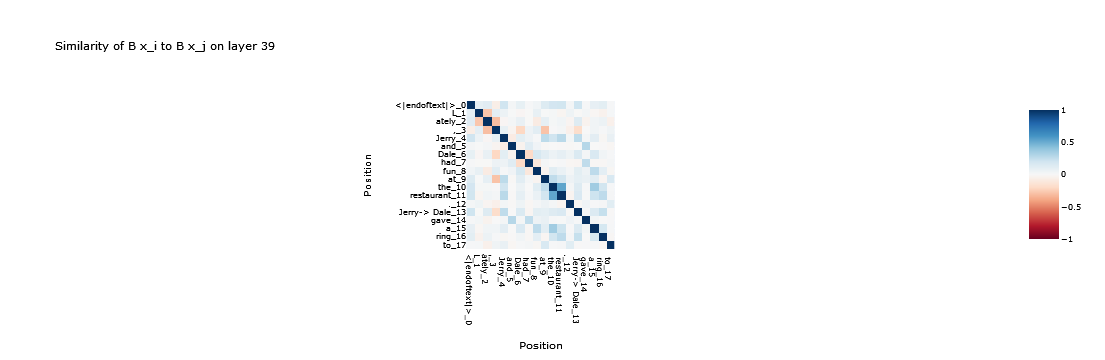

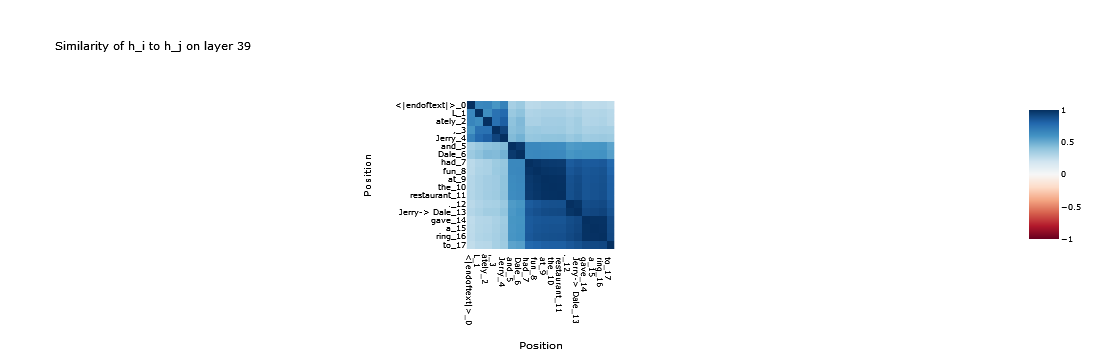

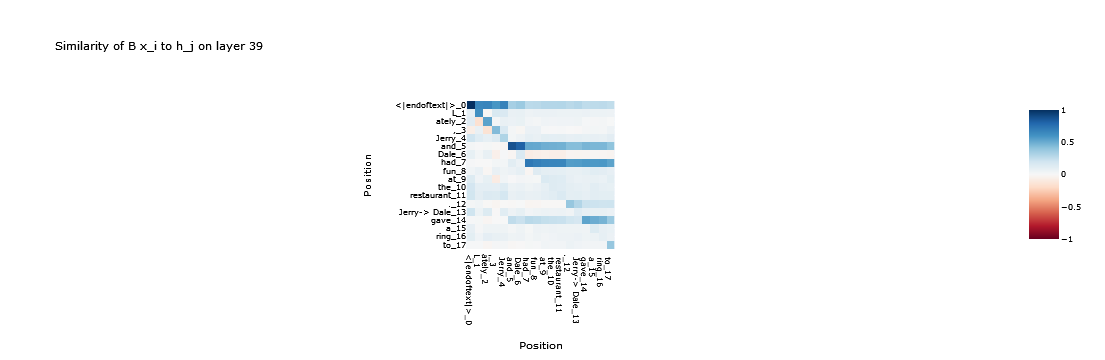

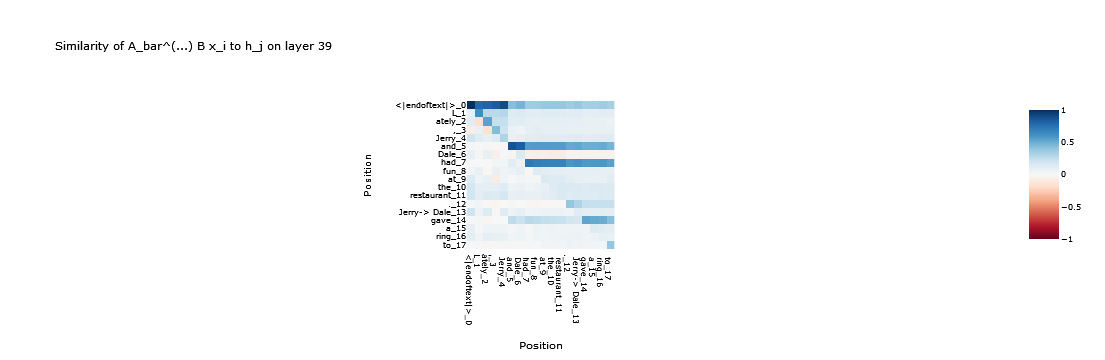

In [19]:

# make token labels that describe the patch
corrupted_str_tokens = model.to_str_tokens(prompt_corrupted_tokens)
uncorrupted_str_tokens = model.to_str_tokens(prompt_uncorrupted_tokens)
token_labels = []
for index, (corrupted_token, uncorrupted_token) in enumerate(zip(corrupted_str_tokens, uncorrupted_str_tokens)):
    if corrupted_token == uncorrupted_token:
        token_labels.append(f"{corrupted_token}_{index}")
    else:
        token_labels.append(f"{uncorrupted_token}->{corrupted_token}_{index}")


# for each pos
'''
layer_labels = [str(layer) for layer in limited_layers]
for pos in tqdm(list(range(L))):
    fig = imshow(h_to_x_b_similarities[:,pos], show=False, x=token_labels, y=layer_labels, xaxis="Position", yaxis="Layer", title=f"Similarity to hidden state of token = {token_labels[pos]}", font_size=8)
    fig.update_layout(**plot_args)
    fig.update_layout(legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    ))
    fig.show()
'''
LAYER = 39
imshow(x_b_similarities[LAYER], show=False, x=token_labels, y=token_labels, xaxis="Position", yaxis="Position", title=f"Similarity of B x_i to B x_j on layer {LAYER}", font_size=8).show()
imshow(h_similarities[LAYER], show=False, x=token_labels, y=token_labels, xaxis="Position", yaxis="Position", title=f"Similarity of h_i to h_j on layer {LAYER}", font_size=8).show()
imshow(h_to_x_b_similarities[LAYER], show=False, x=token_labels, y=token_labels, xaxis="Position", yaxis="Position", title=f"Similarity of B x_i to h_j on layer {LAYER}", font_size=8).show()
imshow(h_to_x_b_similarities_catchup[LAYER], show=False, x=token_labels, y=token_labels, xaxis="Position", yaxis="Position", title=f"Similarity of A_bar^(...) B x_i to h_j on layer {LAYER}", font_size=8).show()



## Interpreting Convs

In [7]:
TOP_N = 200


def get_conv_sims(all_tokens, layer_input_func):
    V,L,D,E = all_tokens.size()[0], 1, model.cfg.D, model.cfg.E
    D_conv = model.cfg.D_conv
    sims = torch.zeros([model.cfg.n_layers,V,D_conv+1], device=model.cfg.device)
    cosine_sims = torch.zeros([model.cfg.n_layers,V,D_conv+1], device=model.cfg.device)
    
    # todo: can we do the same thing for skip connection and B_bar (and maybe A_bar?)
    for INTERPRET_LAYER in tqdm(list(range(model.cfg.n_layers))):
        # [V,1,E]
        conv_input = layer_input_func(all_tokens=all_tokens, layer=INTERPRET_LAYER)
        # [E,1,D_CONV]
        conv_filters = model.blocks[INTERPRET_LAYER].conv1d.weight
        # [V,D]
        conv_input_vecs = conv_input[:,0,:]
        # [V,1]
        conv_input_vecs_mag = torch.linalg.norm(conv_input_vecs, ord=2, dim=1, keepdim=True)
        conv_input_vecs_mag[conv_input_vecs_mag==0] = 1.0 # prevent divide by zero
        # [V,D]                     [V,D]             [V,1]
        conv_input_normalized = conv_input_vecs * 1.0/conv_input_vecs_mag
        
        for conv_i in range(D_conv+1):
            if conv_i < D_conv:
                # [E,1]
                filter = conv_filters[:,0,conv_i].view(E,1)
            else:
                filter = model.blocks[INTERPRET_LAYER].conv1d.bias.view(E,1)
            # [V,L,1]  [V,L,E]   x [E,1]  # basically just [L,E] x [E,1] matmul for every V
            filter_sims    = conv_input @ filter
            # [V]                                  [V]
            sims[INTERPRET_LAYER,:,conv_i] = filter_sims[:,0,0]
        
            # [1]
            filter_mag = torch.linalg.norm(filter.view(E), ord=2, dim=0, keepdim=True)
            filter_mag[filter_mag==0] = 1.0 # no divide by zero
            # [E,1]              [E,1]      [1]
            filter_normalized = filter / filter_mag
            # [V,L,1]  [V,L,E]   x [E,1]  # basically just [L,E] x [E,1] matmul for every V
            filter_cosine_sims    = conv_input_normalized.view(V,1,E) @ filter_normalized
            cosine_sims[INTERPRET_LAYER,:,conv_i] = filter_cosine_sims[:,0,0]
    return sims, cosine_sims

def simple_projected_input(all_tokens, layer):
    # [V,L,D]
    V = all_tokens.size()[0]
    L = 1
    D = model.cfg.D
    input = model.embedding.weight[all_tokens].view(V,L,D)
    # [V,L,D]                                  [V,L,D]
    normalized_input = model.blocks[layer].norm(input)
    # [V,L,E]                        [D->E]     [V,L,D]
    conv_input = model.blocks[layer].in_proj(normalized_input)
    return conv_input

all_tokens = torch.arange(model.cfg.V, device=model.cfg.device)
print(all_tokens.size())
sims, cosine_sims = get_conv_sims(all_tokens=all_tokens, layer_input_func=simple_projected_input)

import pathlib

pathlib.Path("conv interp").mkdir(parents=True, exist_ok=True)
D_conv = model.cfg.D_conv
for INTERPRET_LAYER in range(model.cfg.n_layers):
    with open(f"conv interp/layer {INTERPRET_LAYER} conv sims all.txt", "w") as f:
        def write(s):
            f.write(s + "\n")
        write(f"layer {INTERPRET_LAYER}")
        for conv_i in range(D_conv+1):
            if conv_i == 0: continue # this one is always zeros for some reason
            if conv_i < D_conv:
                write(f"    conv filter {conv_i}")
            else:
                write(f"    bias")
            write(f"      unnormalized sims:")
            top_n = torch.argsort(-sims[INTERPRET_LAYER,:,conv_i])
            for i, tok_i in enumerate(top_n[:TOP_N]):
                tok = all_tokens[tok_i]
                write(f"        top {i} is {tok}={repr(model.tokenizer.decode([tok]))} with sim {sims[INTERPRET_LAYER,tok_i,conv_i]}")
            write(f"      cosine sims:")
            top_n = torch.argsort(-cosine_sims[INTERPRET_LAYER,:,conv_i])
            for i, tok_i in enumerate(top_n[:TOP_N]):
                tok = all_tokens[tok_i]
                write(f"        top {i} is {tok}={repr(model.tokenizer.decode([tok]))} with sim {cosine_sims[INTERPRET_LAYER,tok_i,conv_i]}")
        

torch.Size([50280])


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

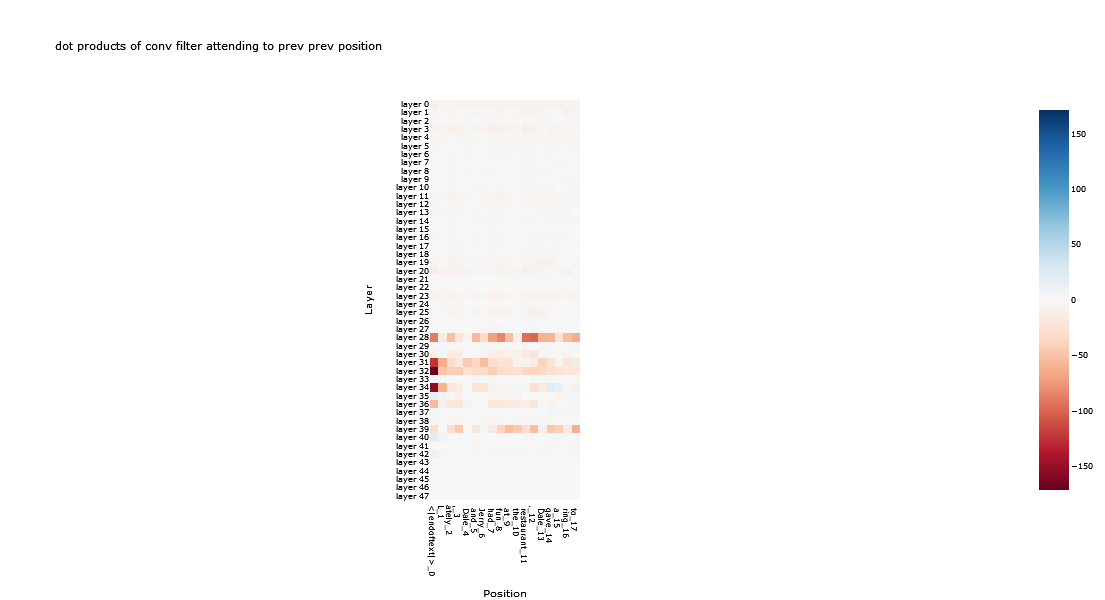

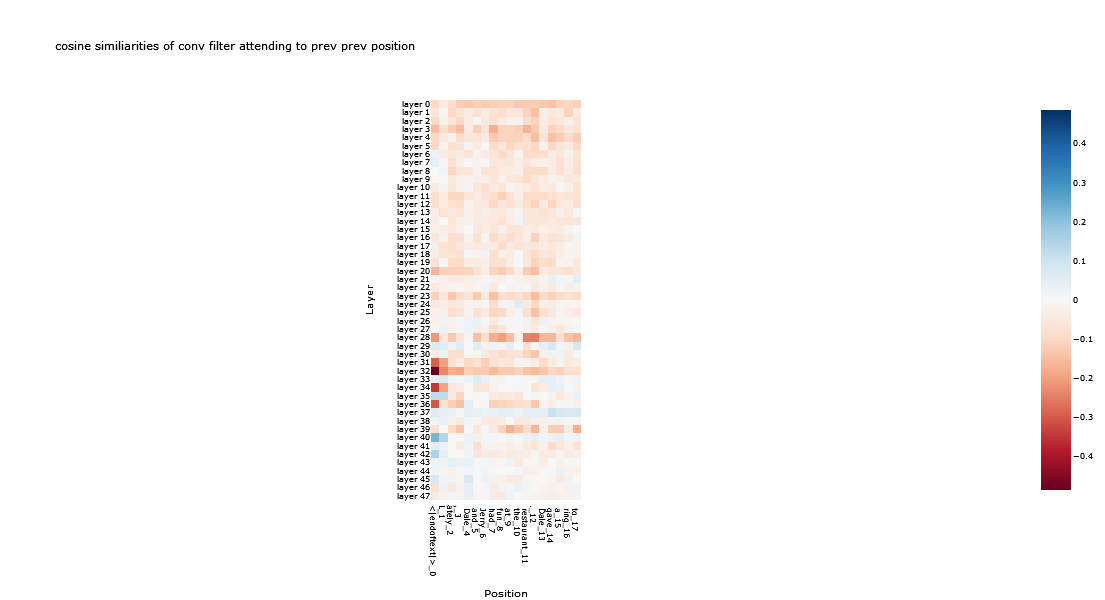

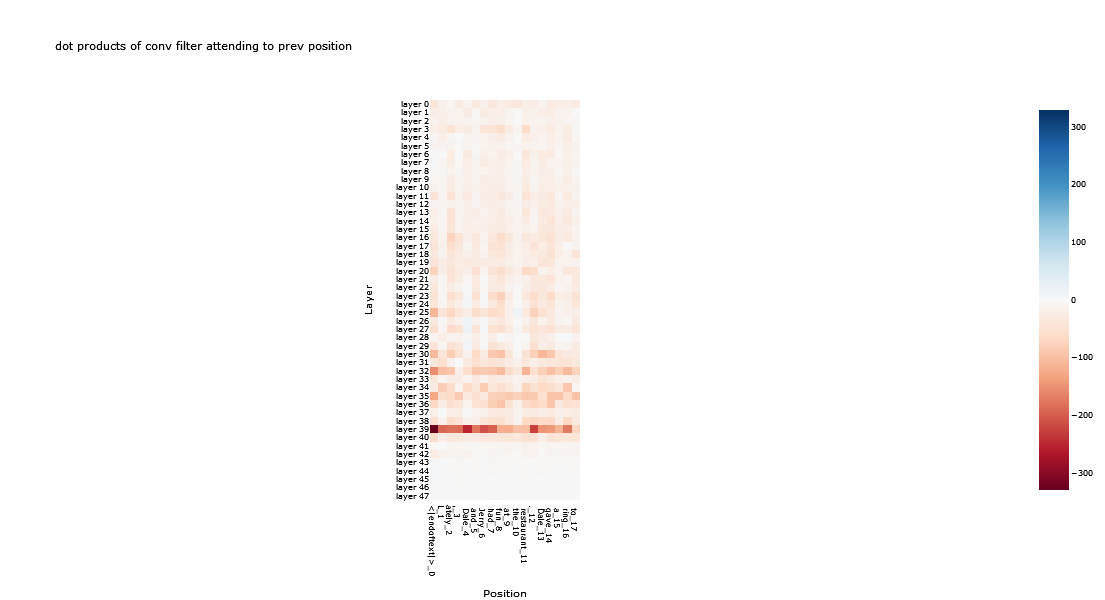

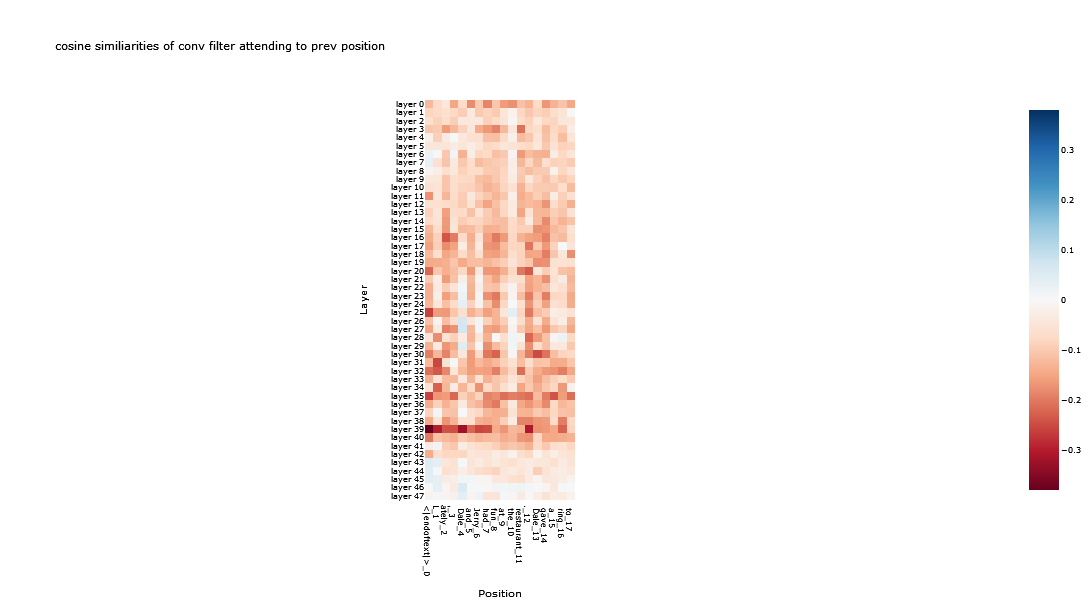

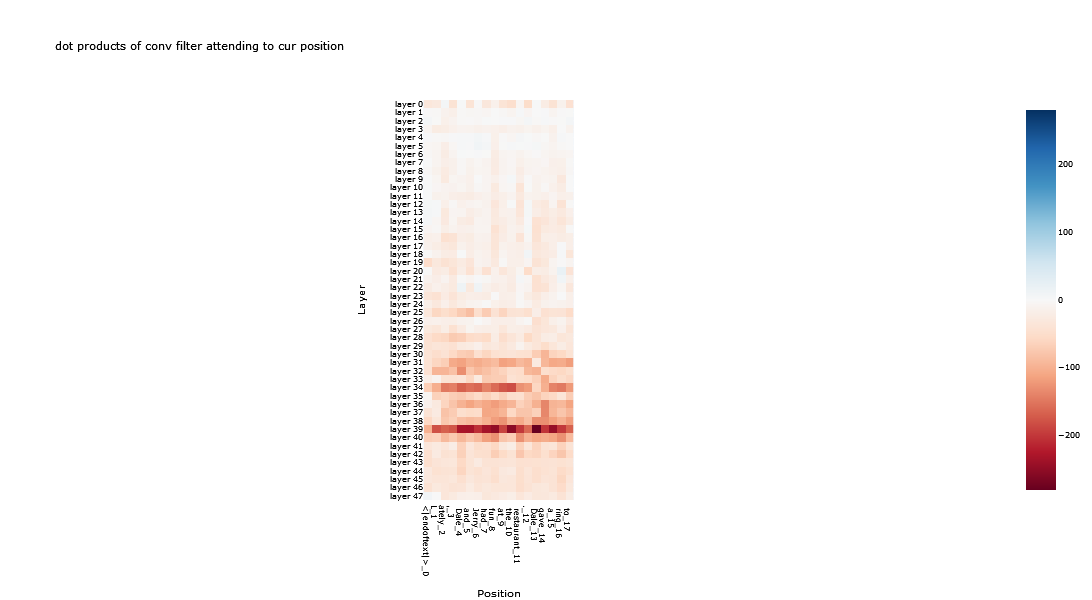

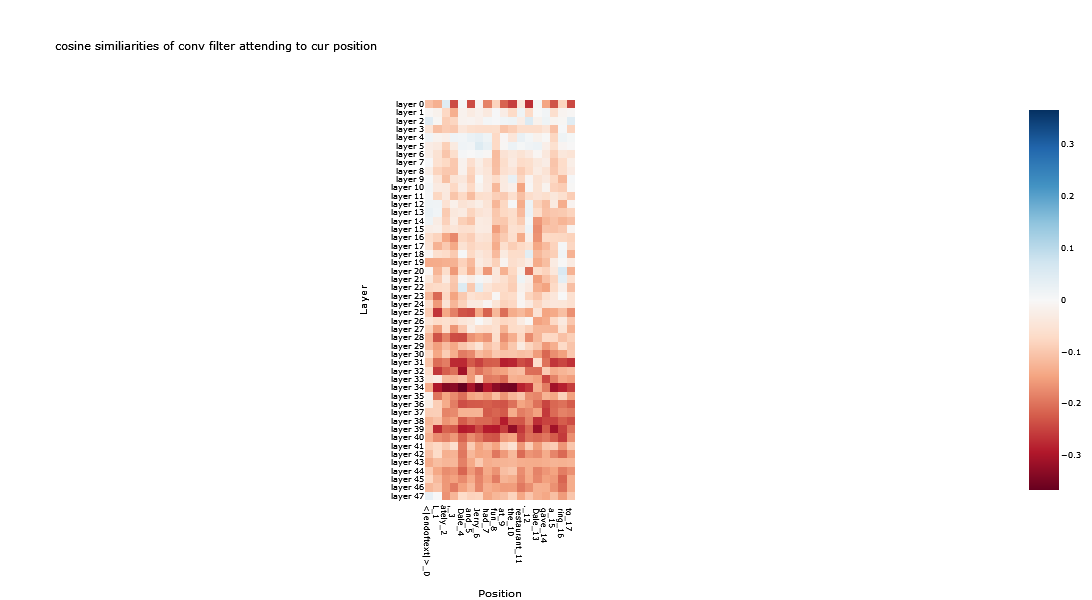

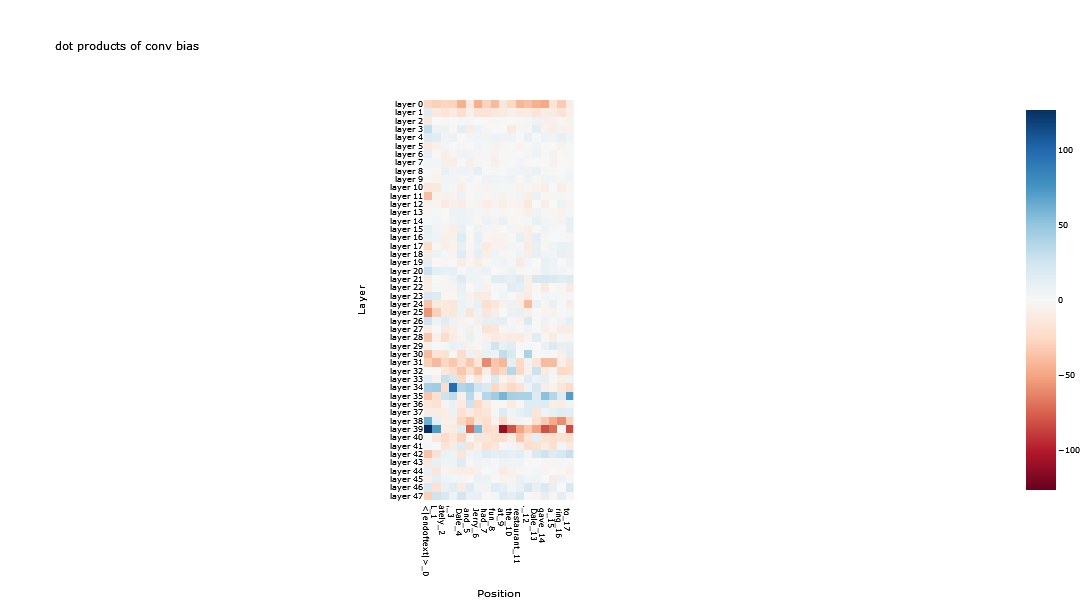

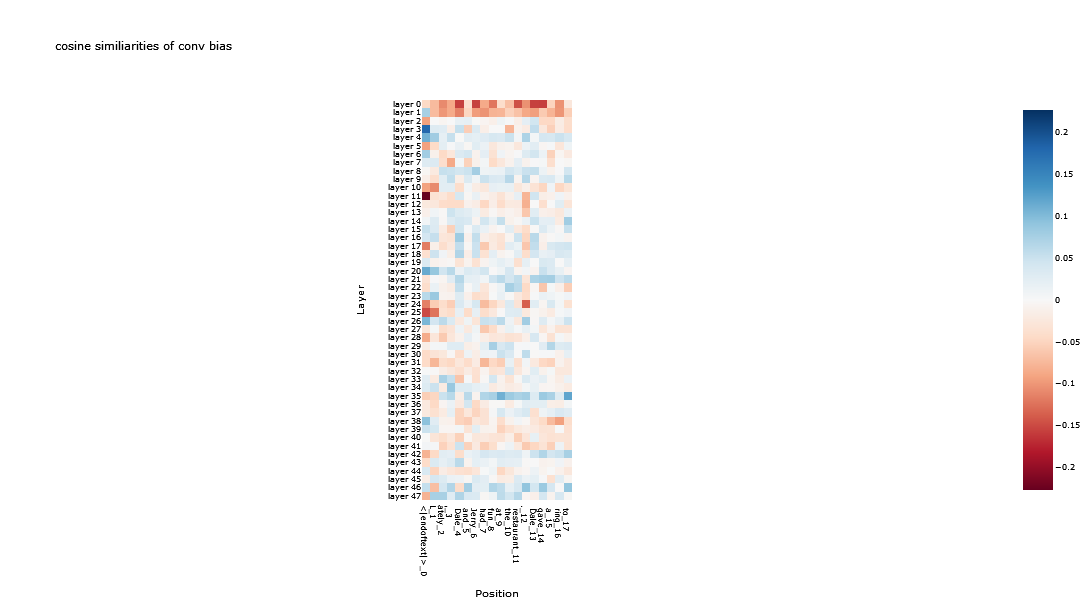

In [14]:
prompt = model.tokenizer.decode(batched_data[0][1:])
prompt_tokens = model.to_tokens(prompt)[0]
L = prompt_tokens.size()[0]
prompt_str_tokens = model.to_str_tokens(prompt_tokens)

token_labels = []
for index, str_token in enumerate(prompt_str_tokens):
    token_labels.append(f"{str_token}_{index}")

in_proj_names = []
for layer in range(model.cfg.n_layers):
    in_proj_names.append(f'blocks.{layer}.hook_in_proj')
logits, activations = model.run_with_cache(prompt_tokens.view(1,-1), names_filter=in_proj_names)

def hooked_layer_inputs(all_tokens, layer):
    # [B,L,E]
    conv_input = activations[f'blocks.{layer}.hook_in_proj']
    B,L,E = conv_input.size()
    return conv_input[0].view(L,1,E)
    
all_tokens = prompt_tokens

sims, cosine_sims = get_conv_sims(all_tokens=prompt_tokens, layer_input_func=hooked_layer_inputs)

conv_name_lookup = ['conv filter attending to cur position', 'conv bias']
for i in range(D_conv-1):
    conv_name_lookup = ["conv filter attending to " + " ".join(['prev']*(i+1)) + " position"] + conv_name_lookup
layer_labels = [f"layer {i}" for i in range(model.cfg.n_layers)]
for conv_i in range(D_conv+1):
    if conv_i == 0: continue
    conv_str = f"{conv_name_lookup[conv_i]}"
    imshow(sims[:,:,conv_i], fix_size=True, x=token_labels, y=layer_labels, xaxis="Position", yaxis="Layer", title=f"dot products of {conv_str}", font_size=8)
    imshow(cosine_sims[:,:,conv_i], fix_size=True, x=token_labels, y=layer_labels, xaxis="Position", yaxis="Layer", title=f"cosine similiarities of {conv_str}", font_size=8)



In [67]:
all_tokens

tensor([    0,    13,    15,    45,   247,   253,   281,   285,   387,   574,
          794,  1523,  2143,  2263,  2419,  2552,  3419,  3534,  3689,  3906,
         3978,  4162,  4382,  4657,  4660,  4675,  5484,  5769,  5818,  5961,
         6039,  6086,  6393,  6416,  6588,  6893,  6939,  7758,  7903,  7948,
         8141,  8652,  8831,  8939,  8969,  9271,  9385,  9756, 10049, 10135,
        10301, 10329, 10497, 10648, 10703, 10734, 10766, 12096, 12447, 12694,
        12885, 13089, 13209, 13268, 14648, 14791, 14861, 14943, 15458, 15541,
        15784, 16225, 16286, 16543, 16700, 16916, 16922, 17361, 17363, 17467,
        18175, 18267, 18707, 18966, 19051, 19669, 19917, 20047, 20145, 20222,
        20344, 20428, 20882, 21088, 21122, 21130, 21438, 21521, 21638, 21804,
        21872, 21960, 22138, 22169, 22463, 22707, 22723, 22739, 22825, 23397,
        23425, 23442, 23801, 23961, 24112, 24465, 24504, 24707, 25005, 25062,
        25063, 25080, 25498, 25579, 25635, 25856, 25975, 26066, 